<a href="https://colab.research.google.com/github/imranhossian607/thesis2.0/blob/main/compare_with_the_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


In [ ]:
!pip install split-folders


In [ ]:
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the dataset into train, validation, and test sets
input_folder = '/content/drive/MyDrive/*Thesis*/data/image data/Dataset'
output_folder = 'output'

splitfolders.ratio(input_folder, output=output_folder, seed=1345, ratio=(0.7, 0.15, 0.15))

# Define data augmentation parameters
WIDTH,HEIGHT=224,224

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,          # Zoom in/out by a maximum of 20%
                                   horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

# Define the directories for your training, validation, and test sets
train_dir = os.path.join(output_folder, 'train')
valid_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

# Apply data augmentation to the training dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (WIDTH,HEIGHT),
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)


# No augmentation for validation and test datasets
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(WIDTH,HEIGHT),   # Adjust the target size as needed
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(WIDTH,HEIGHT),   # Adjust the target size as needed
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)


Copying files: 6400 files [00:22, 283.20 files/s]


Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 962 images belonging to 4 classes.


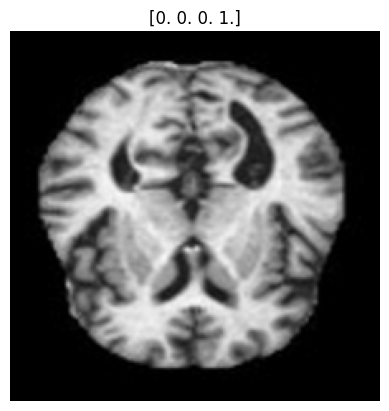

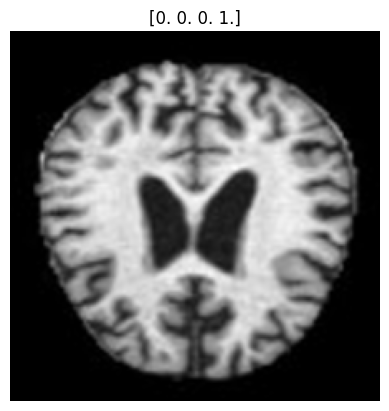

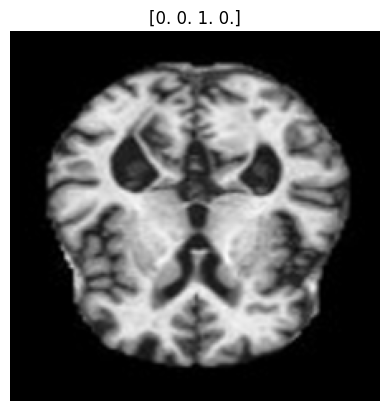

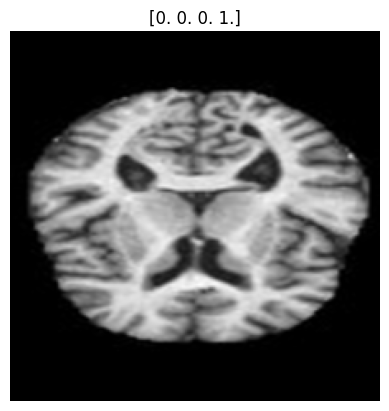

In [ ]:
batch_1_img = train_data[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

#CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras

input_shape = (WIDTH, HEIGHT, 3)

# Define your CNN model
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer="he_normal", input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(4, activation="softmax"))

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)
sns.despine(top=True, right=True, left=False, bottom=False)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font


#Resnet 50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Define the input shape (WIDTH and HEIGHT should be defined)
input_shape = (WIDTH, HEIGHT, 3)

# Create the ResNet-50 model
resnet = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')


# Flatten the ResNet-50 output
x = Flatten()(resnet.output)

# Add a Dense layer for classification
prediction = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=resnet.input, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define the EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Assuming you have 'train_data' and 'valid_data' defined, you can now train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)
sns.despine(top=True, right=True, left=False, bottom=False)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font

#Resnet 101

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Define the input shape
WIDTH, HEIGHT = 224, 224  # Adjust the dimensions according to your data

# Create the ResNet-101 model
resnet = ResNet101(input_shape=(WIDTH, HEIGHT, 3), weights='imagenet', include_top=False)

# Flatten the ResNet-101 output
x = Flatten()(resnet.output)

# Add a Dense layer for classification
prediction = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=resnet.input, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define the EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Assuming you have 'train_data' and 'valid_data' defined, you can now train the model
model_history_resnet = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

In [ ]:

import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font

#InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

# Create a new model by adding custom layers on top of InceptionV3
model = keras.models.Sequential()

# Add the pre-trained InceptionV3 model
model.add(base_model)

# Add custom fully connected layers on top of InceptionV3
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

In [ ]:

import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font

#vgg 16

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Create the VGG16 model
vgg = VGG16(input_shape=(WIDTH,HEIGHT, 3), weights='imagenet', include_top=False)


# Flatten the VGG16 output
x = Flatten()(vgg.output)

# Add a Dense layer for classification
prediction = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=vgg.input, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define the EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Assuming you have 'train_data' and 'valid_data' defined, you can now train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)
sns.despine(top=True, right=True, left=False, bottom=False)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

In [ ]:

import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font


#vgg 19

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Create the VGG19 model
vgg = VGG19(input_shape=(WIDTH, HEIGHT, 3), weights='imagenet', include_top=False)

# Flatten the VGG19 output
x = Flatten()(vgg.output)

# Add a Dense layer for classification
prediction = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=vgg.input, outputs=prediction)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define the EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Assuming you have 'train_data' and 'valid_data' defined, you can now train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)
sns.despine(top=True, right=True, left=False, bottom=False)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

In [ ]:

import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont

visualkeras.layered_view(model, legend=True, ) # selected font


#Result bar chart

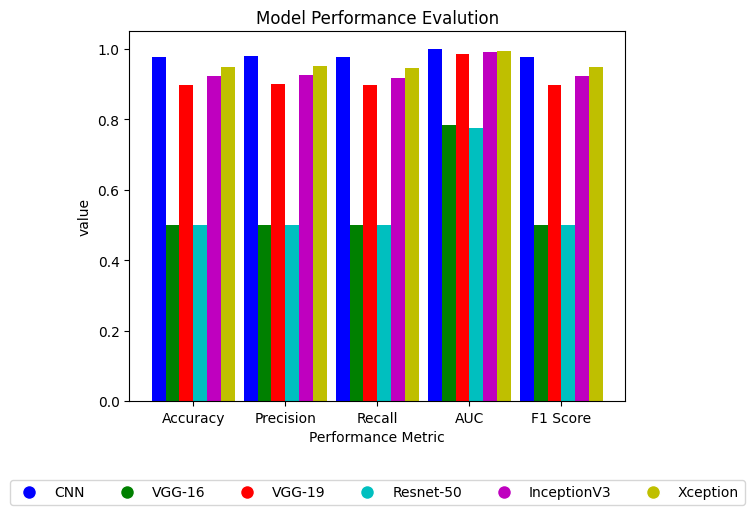

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the performance metrics and their corresponding values
performance_metrics = ["Accuracy", "Precision", "Recall", "AUC", "F1 Score"]
values = {
    "CNN": [0.9761, 0.9791, 0.9761, 0.9993, 0.9776],
    "VGG-16": [0.4990, 0.4990, 0.4990, 0.7831, 0.4990],
    "VGG-19": [0.8981, 0.9007, 0.8960, 0.9867, 0.8984],
    "Resnet-50": [0.4990, 0.4990, 0.4990, 0.7762, 0.4990],
    "InceptionV3": [0.9241, 0.9265, 0.9168, 0.9910, 0.9216],
    "Xception": [0.9470, 0.9499, 0.9460, 0.9950, 0.9479]
}

# Define colors for each model
colors = {
    "CNN": 'b',
    "VGG-16": 'g',
    "VGG-19": 'r',
    "Resnet-50": 'c',
    "InceptionV3": 'm',
    "Xception": 'y'
}

# Create a figure and axis for the main plot
fig, ax = plt.subplots()

# Create a legend for model-color mapping
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model, markersize=10, markerfacecolor=colors[model]) for model in values]

# Define the number of models and performance metrics
num_models = len(values)
num_metrics = len(performance_metrics)

# Set the width of the bars
bar_width = 0.15

# Define an array of evenly spaced values to position the bars on the x-axis
x = np.arange(num_metrics)

# Create a bar for each model with a gap
model_names = list(values.keys())
for i, model in enumerate(model_names):
    performance = values[model]
    ax.bar(x + i * bar_width, performance, width=bar_width, label=model, color=colors[model])

# Set the x-axis labels
ax.set_xticks(x + ((num_models - 1) / 2) * bar_width)
ax.set_xticklabels(performance_metrics)

# Set the legend for model-color mapping
ax.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, -0.3))

# Label the axes
plt.xlabel("Performance Metric")
plt.ylabel("value")

# Set the title
plt.title("Model Performance Evalution")

# Adjust the spacing between subplots to fit the legend
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()
